https://www.kaggle.com/guntherthepenguin/fastai-based-mixed-input-model-lb-3-8

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from IPython.lib.deepreload import reload as dreload
import PIL, os, numpy as np, math, collections, threading, json, bcolz, random, scipy, cv2
import pandas as pd, pickle, sys, itertools, string, sys, re, datetime, time, shutil, copy
import seaborn as sns, matplotlib
import IPython, graphviz, sklearn_pandas, sklearn, warnings, pdb
import contextlib
from abc import abstractmethod
from glob import glob, iglob
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from itertools import chain
from functools import partial
from collections import Iterable, Counter, OrderedDict
from isoweek import Week
from pandas_summary import DataFrameSummary
from IPython.lib.display import FileLink
from PIL import Image, ImageEnhance, ImageOps
from sklearn import metrics, ensemble, preprocessing
from operator import itemgetter, attrgetter
from pathlib import Path
from distutils.version import LooseVersion

from matplotlib import pyplot as plt, rcParams, animation
from ipywidgets import interact, interactive, fixed, widgets
matplotlib.rc('animation', html='html5')
np.set_printoptions(precision=5, linewidth=110, suppress=True)

from ipykernel.kernelapp import IPKernelApp
def in_notebook(): return IPKernelApp.initialized()

def in_ipynb():
    try:
        cls = get_ipython().__class__.__name__
        return cls == 'ZMQInteractiveShell'
    except NameError:
        return False

import tqdm as tq
from tqdm import tqdm_notebook, tnrange

def clear_tqdm():
    inst = getattr(tq.tqdm, '_instances', None)
    if not inst: return
    try:
        for i in range(len(inst)): inst.pop().close()
    except Exception:
        pass

if in_notebook():
    def tqdm(*args, **kwargs):
        clear_tqdm()
        return tq.tqdm(*args, file=sys.stdout, **kwargs)
    def trange(*args, **kwargs):
        clear_tqdm()
        return tq.trange(*args, file=sys.stdout, **kwargs)
else:
    from tqdm import tqdm, trange
    tnrange=trange
    tqdm_notebook=tqdm


from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz


def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ 
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ 
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ 
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]
    return DataFrameMapper(cat_maps).fit(df), DataFrameMapper(contin_maps).fit(df)

In [6]:
path='../input/'

In [7]:
new_transactions = pd.read_csv(f'{path}new_merchant_transactions.csv')
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [8]:
new_transactions['authorized_flag'] = new_transactions['authorized_flag']=='Y'

In [9]:
def aggregate_new_transactions(new_trans):    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_trans = aggregate_new_transactions(new_transactions)
new_trans.head()

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_merchant_id_nunique,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2.0,True,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.0,1,1,0.000000,2,2
1,C_ID_0001238066,26,26.0,True,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
2,C_ID_0001506ef0,2,2.0,True,1,1,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.0,0,0,0.000000,1,1
3,C_ID_0001793786,31,31.0,True,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
4,C_ID_000183fdda,11,11.0,True,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2


In [10]:
del new_transactions

In [11]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [12]:
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag']=='Y'

In [13]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_historical_transactions(historical_transactions)
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_merchant_id_nunique,hist_city_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,149,114.0,0.765101,29,4,-76.845041,-0.587627,1.507069,-0.728876,0.298141,192,1.0,6,1,0.764900,32627654.0,-12,0
1,C_ID_0001238066,123,120.0,0.975610,65,18,-72.447201,-0.648184,0.768095,-0.734887,0.190235,198,1.0,10,-1,1.485637,13110825.0,-5,0
2,C_ID_0001506ef0,66,62.0,0.939394,28,3,-34.601879,-0.703707,1.493545,-0.740491,0.472284,1,0.0,1,0,0.123091,34460275.0,-13,0
3,C_ID_0001793786,216,189.0,0.875000,119,10,-36.786013,-0.487911,4.554145,-0.745405,0.836046,5,0.0,1,0,0.150723,24487497.0,-9,0
4,C_ID_000183fdda,144,137.0,0.951389,73,9,-68.837938,-0.661294,2.764788,-0.737892,0.524948,264,1.0,10,-1,2.118846,17492874.0,-6,0


In [14]:
del historical_transactions

In [15]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    add_datepart(df,'first_active_month')
    return df
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')

target='target'


In [16]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new_trans, on='card_id', how='left')
test = pd.merge(test, new_trans, on='card_id', how='left')

In [17]:
train=train.set_index('card_id')
test=test.set_index('card_id')

In [18]:
cat_vars = [col  for col in train.columns if('feature' in col or 'first_active_month' in col)]
contin_vars = [col  for col in train.columns if ('feature' not in col and 'first_active_month' not in col) and target not in col]

In [19]:
train = train[cat_vars+contin_vars+[target]].copy()
n = len(train); n

201917

In [20]:
test[target] = 0
test = test[cat_vars+contin_vars+[target]].copy()

In [21]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)

In [22]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [25]:
df_trn, y, nas, mapper = proc_df(train, target, do_scale=True)
n=len(df);n

201917

In [39]:
df_test, _, nas, mapper = proc_df(test, target, do_scale=True, 
                                  mapper=mapper, na_dict=nas)

In [27]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()



n_valid = int(len(df_trn) * .25)
n_trn = len(df_trn)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((151438, 51), (151438,), (50479, 51))

In [28]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [30]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

In [32]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.7814881014308206, 3.9165634599025725, 0.017853889365444964, 0.0183225860652817]


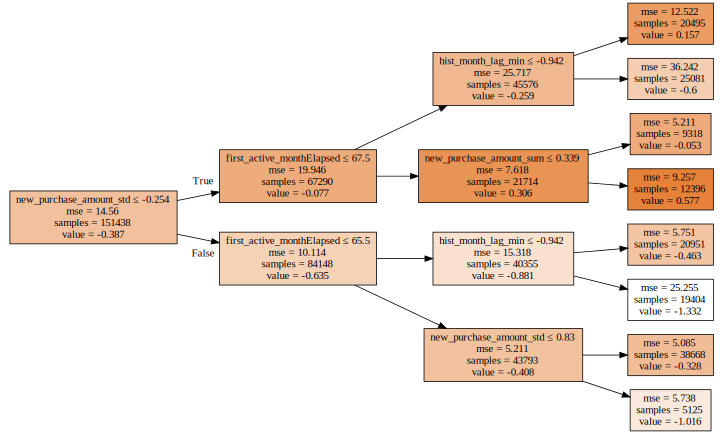

In [33]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [34]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.107821488271007e-05, 5.583263680881021, 0.9999999999915707, -0.9949625205054213]


In [51]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True) #40
m.fit(X_train, y_train)
print_score(m)

[1.4148365566041787, 3.8669297110615055, 0.8625125142838869, 0.043046093973298505, 0.0006565322846157073]


In [56]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) #40
m.fit(X_train, y_train)
print_score(m)

[1.397918683383142, 3.845792699955764, 0.8657808625931221, 0.05347910676745992, 0.021193299965712287]


In [61]:
m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, n_jobs=-1, oob_score=True) #40
m.fit(X_train, y_train)
print_score(m)

[2.344974274499695, 3.8219548959720817, 0.6223175627260404, 0.06517659228651107, 0.0415863870900427]


In [57]:
prediction = m.predict(df_test)

In [58]:
from datetime import datetime
ids = df_test.index.values
vals = prediction
sub = pd.DataFrame({'card_id': ids, 'target': vals})
sub.to_csv("submission-elo-%s.csv"%datetime.now().date(), index = False, header = True)
sub.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.503089
1,C_ID_130fd0cbdd,-0.377011
2,C_ID_b709037bc5,-1.041819
3,C_ID_d27d835a9f,0.175081
4,C_ID_2b5e3df5c2,-1.836249


In [59]:
np.max(sub), np.min(sub)

(card_id    C_ID_ffff756266
 target             5.91688
 dtype: object, card_id    C_ID_0001238066
 target            -18.8999
 dtype: object)

In [60]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  __notebook_source__.ipynb
  submission-elo-2019-01-13.csv

## Feature importance

In [64]:
fi = rf_feat_importance(m,X_train); fi[:10]

,cols,imp
31,hist_purchase_date_ptp,0.069437
18,hist_authorized_flag_mean,0.065053
22,hist_purchase_amount_median,0.061022
24,hist_purchase_amount_min,0.051166
26,hist_installments_sum,0.047395
23,hist_purchase_amount_max,0.046512
21,hist_purchase_amount_sum,0.045307
25,hist_purchase_amount_std,0.044753
41,new_purchase_amount_max,0.043135
19,hist_merchant_id_nunique,0.040718
